In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
from tensorflow.keras import layers, models
import sklearn.metrics as metrics

%matplotlib notebook

In [2]:
#@title Training constants

window_size = 50 #@param {type:"number"} 
step_size = 5 #@param {type:"number"}

sensor_pos = 'Chest' #@param {type:"string"}
sensor_side = 'Right' #@param {type:"string"}

train_pct = 0.8 #@param {type:"number"}

learn_rate = 0.0001 #@param {type:"number"}
batch_size = 200 #@param {type:"number"}
num_epochs = 200 #@param {type:"number"}

output_model_filename = f"cnn_w{window_size}_b{batch_size}_e{num_epochs}"
intermediate_model_filename = "cnn_model_intermediate"
##@param {type:"slider", min:1, max:1000, step:1}

# Load data

In [3]:
data_root = Path('.')/'data'
!git clone https://github.com/specknet/pdiot-data.git $data_root

fatal: destination path 'data' already exists and is not an empty directory.


In [4]:
target_folder = data_root/'2020'
student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    # print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
{k: len(v) for (k, v) in files.items()}

File count:


{'s1616573': 94,
 's1621503': 84,
 's1642301': 84,
 's1655560': 78,
 's1660711': 84,
 's1701688': 84,
 's1704037': 80,
 's1709221': 71,
 's1710228': 84,
 's1711507': 233,
 's1721039': 81,
 's1735229': 84,
 's1736273': 84,
 's1737472': 78,
 's1746788': 84,
 's1758009': 78,
 's1758499': 84,
 's1764751': 92,
 's1768094': 165,
 's1770036': 78,
 's2017768': 11}

In [5]:
ACTIVITY_CODE_TO_TFCODE_MAPPING = {
  0:   0,   # "Sitting",
  4:   1,   # "Sitting bent forward",
  5:   2,   # "Sitting bent backward",
  1:   3,   # "Walking at normal speed",
  100: 4,   # "Standing",
  2:   5,   # "Lying down on back",
  7:   6,   # "Lying down left",
  6:   7,   # "Lying down right",
  8:   8,   # "Lying down on stomach",
  9:   9,   # "Movement",
  11:  10,  # "Running",
  12:  11,  # "Climbing stairs",
  13:  12,  # "Descending stairs",
  31:  13,  # "Desk work"
}

ACTIVITY_TFCODE_TO_CODE_MAPPING = {
  0:  0,   # "Sitting",
  1:  4,   # "Sitting bent forward",
  2:  5,   # "Sitting bent backward",
  3:  1,   # "Walking at normal speed",
  4:  100, # "Standing",
  5:  2,   # "Lying down on back",
  6:  7,   # "Lying down left",
  7:  6,   # "Lying down right",
  8:  8,   # "Lying down on stomach",
  9:  9,   # "Movement",
  10: 11,  # "Running",
  11: 12,  # "Climbing stairs",
  12: 13,  # "Descending stairs",
  13: 31,  # "Desk work"
}

LABELS = {
    0:  "Sitting",
    1:  "Sitting bent forward",
    2:  "Sitting bent backward",
    3:  "Walking at normal speed",
    4:  "Standing",
    5:  "Lying down on back",
    6:  "Lying down left",
    7:  "Lying down right",
    8:  "Lying down on stomach",
    9:  "Movement",
    10: "Running",
    11: "Climbing stairs",
    12: "Descending stairs",
    13: "Desk work"
}

In [6]:
from dataclasses import dataclass

header_size = 5

@dataclass
class Header:
  sensor_pos: str
  sensor_side: str
  act_type: str
  act_code: np.ndarray
  subject_id: str
  # https://stackoverflow.com/a/54863771/9184658
  def __post_init__(self):
    self.act_code = ACTIVITY_CODE_TO_TFCODE_MAPPING[int(self.act_code)]


@dataclass
class Activity:
  header: Header
  df: pd.DataFrame

def read_custom_file(filename):
  with open(filename) as f:
    head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
    # print(head)
    header = Header(*[s.split(': ')[1] for s in head])
    # for l in head:
    #   print(l)
    # print(header)

    df = pd.read_csv(filename, header=header_size)
    return Activity(header, df)

In [7]:
def plot_respeck_fig(df):
  fig = plt.figure(figsize=(10, 8))
  plt.plot(df['accel_x'], label="accel_x")
  plt.plot(df['accel_y'], label="accel_y")
  plt.plot(df['accel_z'], label="accel_z")
  plt.legend()
  return plt

In [8]:
act = read_custom_file(files["s1621503"][0])
act

Activity(header=Header(sensor_pos='Chest', sensor_side='Right', act_type='Standing', act_code=4, subject_id='s1621503'), df=         timestamp  seq   accel_x   accel_y   accel_z
0    1601636541113    0 -0.013184 -0.957336  0.080750
1    1601636541113    1  0.038574 -0.997131  0.133240
2    1601636541114    2  0.035400 -0.953430  0.128357
3    1601636541115    3  0.097900 -0.973694  0.141052
4    1601636541115    4  0.079590 -0.975403  0.111267
..             ...  ...       ...       ...       ...
411  1601636572275  411  0.252197 -0.917542  0.260437
412  1601636572275  412  0.249023 -0.915344  0.262634
413  1601636572276  413  0.249268 -0.915100  0.257507
414  1601636572278  414  0.249512 -0.919739  0.258728
415  1601636572278  415  0.251709 -0.914856  0.261902

[416 rows x 5 columns])

In [9]:
keys = ["accel_x", "accel_y", "accel_z"]

In [10]:
# split students into train and test set

students = list(files.keys())
    
split = int(len(students) * train_pct)
train_students = students[:split]
test_students = students[split:]
test_students

['s1721039', 's1710228', 's1709221', 's1746788', 's1704037']

In [11]:
def get_activities(files, students, window_size, sensor_pos, sensor_side):
  student_files = [files[student] for student in students]
  activities = []
  for student in student_files:
    for filename in student:
      try:
        # a = [read_custom_file(filename) for student in student_files for filename in student]
        a = read_custom_file(filename)
        if not a.df.empty and len(a.df.index) >= window_size and a.header.sensor_pos == sensor_pos and a.header.sensor_side == sensor_side:
          activities.append(a)
        # activities.extend([activity for activity in a if not activity.df.empty and len(activity.df.index) >= window_size and activity.header.sensor_pos == sensor_pos and activity.header.sensor_side == sensor_side])
      except Exception as e:
        print(f"error: {filename}")
        # raise e

  return activities

In [12]:
train_activities = get_activities(files, train_students, window_size, sensor_pos, sensor_side)

test_activities = get_activities(files, test_students, window_size, sensor_pos, sensor_side)

print("loaded")

error: data/2020/s1770036/s1770036_Running_Chest_Left_1603035399338.csv
error: data/2020/s1770036/s1770036_Walking at normal speed_Front pocket (trouser)_Left_1603024579453.csv
error: data/2020/s1770036/s1770036_Walking at normal speed_Chest_Left_1603035136711.csv
error: data/2020/s1770036/s1770036_Descending stairs_Wrist_Left_1603033555964.csv
error: data/2020/s1770036/s1770036_Climbing stairs_Wrist_Left_1603033515019.csv
error: data/2020/s1770036/s1770036_Walking at normal speed_Front pocket (trouser)_Right_1603024522379.csv
error: data/2020/s1770036/s1770036_Running_Front pocket (trouser)_Left_1603024642797.csv
error: data/2020/s1737472/s1737472_Climbing stairs_Front pocket (trouser)_Right_1601161748026.csv
error: data/2020/s1737472/s1737472_Descending stairs_Front pocket (trouser)_Right_1601161679064.csv
error: data/2020/s1737472/s1737472_Sitting bent forward_Chest_Right_1601128865590.csv
error: data/2020/s1737472/s1737472_Descending stairs_Front pocket (trouser)_Left_1601161532220

# Prep data

In [13]:
# X = data
# Y = labels

def create_data_arrays(activities):
    data = np.array([activity.df.get(keys).values for activity in activities], dtype=object)
    labels = np.array([activity.header.act_code for activity in activities])
    
    return data, labels

In [14]:
train_data_raw, train_labels_raw = create_data_arrays(train_activities)

test_data_raw, test_labels_raw = create_data_arrays(test_activities)


In [15]:
# one hot encoding of output labels

train_labels = np.array(pd.get_dummies(train_labels_raw))
test_labels = np.array(pd.get_dummies(test_labels_raw))

In [16]:
def standardize(X):
    x = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    return x

def standardize_array(data_raw):
    data = np.zeros(data_raw.shape, dtype=object)
    
    for i in range(len(data)):
        data[i] = (standardize(data_raw[i]))
        
    return data

In [17]:
# standardize input data

train_data = train_data_raw # standardize_array(train_data_raw)

test_data = test_data_raw # standardize_array(test_data_raw)

In [18]:
def window_data(data_array, label_array, window_size, step_size):
    windowed_data = []
    windowed_labels = []
    
    for i in range(len(label_array)):
        arr = data_array[i]
        label = label_array[i]
        start_i = 0
        end_i = start_i + window_size

        while end_i < arr.shape[0]:
            windowed_data.append(arr[start_i:end_i])
            windowed_labels.append(label)
            start_i = start_i + step_size
            end_i = start_i + window_size
        
    return np.array(windowed_data), np.array(windowed_labels)

In [19]:
train_data_win, train_label_win = window_data(train_data, train_labels, window_size, step_size)

test_data_win, test_label_win = window_data(test_data, test_labels, window_size, step_size)

print(train_data_win.shape)
print(train_label_win.shape)

print(test_data_win.shape)
print(test_label_win.shape)

(30462, 50, 3)
(30462, 14)
(9958, 50, 3)
(9958, 14)


In [20]:
# variable length inputs
# use batch size = 1

x = train_data_win
y = train_label_win

num_channels = x.shape[2]
num_classes = y.shape[1]

seq_len = x.shape[1]

num_inputs = x.shape[0]
num_outputs = y.shape[0]



In [21]:
def save_model(model, n, base_filename):
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    model_filename = Path('models')/"_".join(map(str, [base_filename, n, sensor_pos, sensor_side])) # + ".tflite"
    # Save the model.
    with open(model_filename, 'wb') as f:
        f.write(tflite_model)

In [22]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 0, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r, output_model_filename)
    
    #print(predictions)
    
    return accuracy

In [23]:
# fit and evaluate a model
def evaluate_model_2(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 0, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r, output_model_filename)
    
    #print(predictions)
    
    return accuracy

In [24]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [25]:
# run an experiment
def run_experiment(trainX, trainy, testX, testy, repeats=1):
    # repeat experiment
    scores = list()
    models = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy, r)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        models.append
    # summarize results
    summarize_results(scores)
    


In [26]:
def get_predictions_from_saved_model(model_filename, testX):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_filename)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for x in testX:
        interpreter.set_tensor(input_details[0]['index'], [x])
    
        interpreter.invoke()
    
        predictions.append(interpreter.get_tensor(output_details[0]['index']))
    
    return np.array(predictions)

# Train

In [27]:
run_experiment(train_data_win, train_label_win, test_data_win, test_label_win, 5)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpbagka98l/assets
>#1: 54.057
INFO:tensorflow:Assets written to: /tmp/tmps3ze3rs9/assets


INFO:tensorflow:Assets written to: /tmp/tmps3ze3rs9/assets


>#2: 57.100
INFO:tensorflow:Assets written to: /tmp/tmpjg6krcup/assets


INFO:tensorflow:Assets written to: /tmp/tmpjg6krcup/assets


>#3: 57.040
INFO:tensorflow:Assets written to: /tmp/tmpwusmbpui/assets


INFO:tensorflow:Assets written to: /tmp/tmpwusmbpui/assets


>#4: 53.254
INFO:tensorflow:Assets written to: /tmp/tmpt8ehjmwn/assets


INFO:tensorflow:Assets written to: /tmp/tmpt8ehjmwn/assets


>#5: 53.354
[54.05703783035278, 57.09981918334961, 57.03956484794617, 53.25366258621216, 53.354084491729736]
Accuracy: 54.961% (+/-1.744)


In [28]:
raise Exception("Stopping for model selection")

Exception: ignored

In [30]:
model = "cnn_w50_b200_e200_2_Chest_Right"
predictions = get_predictions_from_saved_model(str(Path('models') / model), np.array(test_data_win, dtype=np.float32))

In [31]:
predictions.shape

(9958, 1, 14)

In [32]:
classes = {
  'sitting': [0, 1, 2], 
  'standing': [4], 
  'lying': [5, 6, 7, 8],
  'walking': [3],
  'movement': [9],
  'running': [10],
  'climbing_stairs':[11],
  'descending_stairs': [12],
  'desk_work': [13]
}

In [33]:
pred_labels = np.argmax(predictions, axis=2)

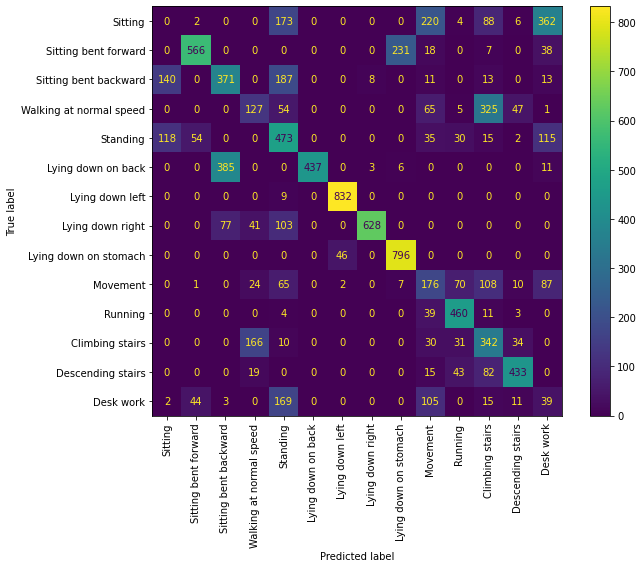

In [34]:
cm = metrics.confusion_matrix(np.argmax(test_label_win, axis=1), pred_labels)

fig, ax = plt.subplots(figsize=(10, 8))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
disp.plot(xticks_rotation='vertical', values_format="d", ax=ax)
# plt.show()
plt.tight_layout()
plt.savefig(f"{model}_cm.png")

# Extra metrics

In [35]:
standardisation = [31.55737817287445, 33.42026770114899, 30.02980649471283, 33.23397934436798, 30.29060959815979]
epochs_10 = [42.473918199539185, 39.71683979034424, 29.88077402114868, 39.30700421333313, 46.050670742988586]
epochs_20 = [41.840535402297974, 33.196720480918884, 37.89120614528656, 45.90163826942444, 38.226526975631714]
epochs_30 = [40.387481451034546, 45.566317439079285, 36.810728907585144, 43.3308482170105, 36.62444055080414]
epochs_40 = [39.82861340045929, 32.82414376735687, 42.324888706207275, 46.460506319999695, 43.66616904735565]


window_50_epochs_40 = [37.38650977611542, 37.87289261817932, 40.4020756483078, 38.197147846221924, 37.02983260154724]
window_150_epochs_40 = [46.45358920097351, 40.49912393093109, 42.3380047082901, 37.25919425487518, 44.78984177112579]


layers_3_10 = [35.99105775356293, 33.79284739494324, 41.09537899494171, 41.46795868873596, 42.17585623264313]
layers_3_30 = [43.96423101425171, 35.58122217655182, 42.324888706207275, 43.8152015209198, 32.97317326068878]
layers_3_filters_32 = [39.493292570114136, 40.83457589149475, 31.929954886436462, 33.830103278160095, 39.67958390712738]
layers_3_filters_128 = [30.588674545288086, 46.16244435310364, 32.22801685333252, 30.81222176551819, 42.36214458942413]


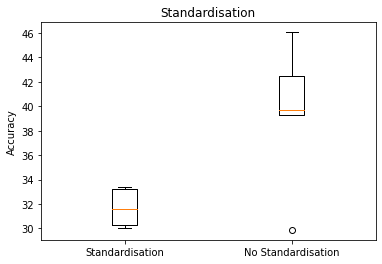

In [36]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Standardisation')
ax1.boxplot([standardisation, epochs_10], labels=['Standardisation', 'No Standardisation'])
plt.show()

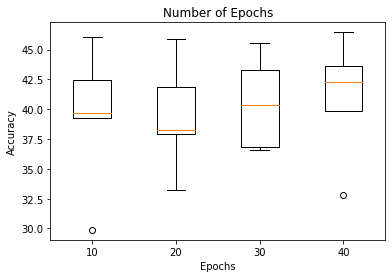

In [37]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Epochs')
ax1.boxplot([epochs_10, epochs_20, epochs_30, epochs_40], labels=['10', '20', '30', '40'])
plt.show()

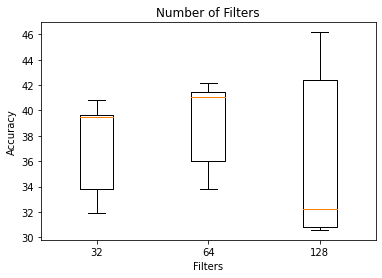

In [38]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Filters')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Filters')
ax1.boxplot([layers_3_filters_32, layers_3_10, layers_3_filters_128], labels=['32', '64', '128'])
plt.show()

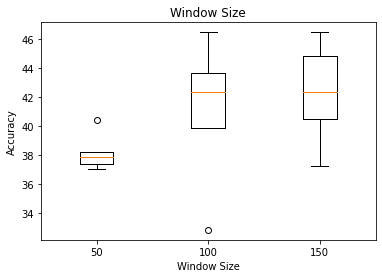

In [39]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Window Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Window Size')
ax1.boxplot([window_50_epochs_40, epochs_40, window_150_epochs_40], labels=['50', '100', '150'])
plt.show()

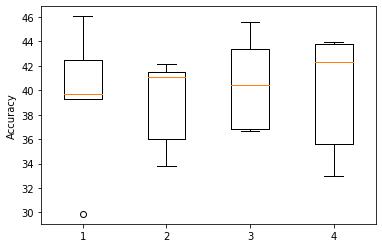

In [40]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.boxplot([epochs_10, layers_3_10, epochs_30, layers_3_30], labels=['1', '2', '3','4'])
plt.show()